# Field data inverse dynamics regression (wind coefficients)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from sklearn.metrics import mean_squared_error
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator, function_eq, subs_simpler
from scipy.optimize import least_squares
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
import statsmodels.api as sm
import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='7m'
model_loaders = catalog.load(f"{ship}.models")
time_series = catalog.load(f"{ship}.tests_ek_smooth")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
ship_data = catalog.load(f"{ship}.ship_data")
units = catalog.load(f"{ship}.units")

[07/17/23 09:59:46] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=65604;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=885164;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/17/23 09:59:56] INFO     Kedro project phd                                                      ]8;id=50354;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=389631;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=931943;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=753501;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=797465;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=423168;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=843825;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=291304;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.tests_ek_smooth' (PartitionedDataSet)...     ]8;id=487075;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=471349;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=809048;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=897530;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=374523;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=596180;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=971191;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=441109;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model_original = model_loaders['vmm_7m_vct_wind.VCT_MDL_resistance']()
model = model_original.copy()

In [5]:
model.subsystems.keys()

dict_keys(['hull', 'propellers', 'rudders', 'wind_force'])

In [6]:
propellers = model.subsystems['propellers']
propellers.equations

{'thrust': Eq(thrust, D**2*n_prop*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g)),
 'X_P': Eq(X_P, X_{thrust}*thrust),
 'Y_P': Eq(Y_P, 0),
 'N_P': Eq(N_P, 0)}

In [7]:
propellers.lambdas

{'thrust': <function _lambdifygenerated(C0_w_p0, C1_w_p0, D, L, U, g, k_0, k_1, k_2, n_prop, rev, rho, u)>,
 'X_P': <function _lambdifygenerated(Xthrust, thrust)>,
 'Y_P': <function _lambdifygenerated()>,
 'N_P': <function _lambdifygenerated()>}

In [8]:
wind_force = model.subsystems['wind_force']

In [9]:
wind_force.equations

{'cog': Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi))),
 'aws': Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2)),
 'awa': Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi),
 'X_W': Eq(X_W, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa)),
 'Y_W': Eq(Y_W, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa) + A_YV*C_y3*awa**3*aws**2*rho_A),
 'N_W': Eq(N_W, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)}

In [10]:
model.X_eq

Eq(m*(\dot{u} - r**2*x_G - r*v), X_{\dot{u}}*\dot{u} + X_H(u, v, r, delta) + X_P(u, v, r, rev) + X_R(u, v, r, delta, thrust) + X_W(C_x5, C_x2, C_x4, C_x1, A_XV, rho_A, aws, C_x3, C_x0, awa))

In [11]:
eq_X_W = sp.Eq(X_W, sp.solve(model.X_eq, model.X_eq.rhs.args[4])[0])
eq_Y_W = sp.Eq(Y_W, sp.solve(model.Y_eq, model.Y_eq.rhs.args[5])[0])
eq_N_W = sp.Eq(N_W, sp.solve(model.N_eq, model.N_eq.rhs.args[5])[0])

display(eq_X_W)
display(eq_Y_W)
display(eq_N_W)



Eq(X_W, -X_{\dot{u}}*\dot{u} + \dot{u}*m - m*r**2*x_G - m*r*v - X_H(u, v, r, delta) - X_P(u, v, r, rev) - X_R(u, v, r, delta, thrust))

Eq(Y_W, -Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u - Y_H(u, v, r, delta) - Y_P(u, v, r, rev) - Y_R(u, v, r, delta, thrust))

Eq(N_W, I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + \dot{v}*m*x_G + m*r*u*x_G - N_H(u, v, r, delta) - N_P(u, v, r, rev) - N_R(u, v, r, delta, thrust))

In [96]:
id=1
data = time_series[str(id)]()
data['delta']+=np.deg2rad(1.8)
#data['delta']+=np.deg2rad(2.5)
df_force = model.forces_from_motions(data=data)

In [97]:
# Precalculate the hulle, propellers, and rudders:
calculation = {}
for system_name, system in model.subsystems.items():
    if system_name == "wind_force":
        for key, eq in system.lambdas.items():
            try:
                calculation[key] = run(eq, inputs=data, **calculation, **ship_data)
            except:
                log.warning(f"Skipping:{key}")
                continue
    system.calculate_forces(
        states_dict=data[model.states_str],
        control=data[model.control_keys],
        calculation=calculation,
        allow_double_calc=True,
    )
    

df_calculation = pd.DataFrame(calculation, index=data.index)
data = pd.concat((data.drop(columns=['awa','aws']), df_calculation), axis=1)
#data = data.T.drop_duplicates().T

[07/17/23 10:24:19] WARNING  Skipping:X_W                                                           ]8;id=672377;file:///tmp/ipykernel_25172/2733935428.py\2733935428.py]8;;\:]8;id=486334;file:///tmp/ipykernel_25172/2733935428.py#9\9]8;;\

                    WARNING  Skipping:Y_W                                                           ]8;id=101782;file:///tmp/ipykernel_25172/2733935428.py\2733935428.py]8;;\:]8;id=607653;file:///tmp/ipykernel_25172/2733935428.py#9\9]8;;\

                    WARNING  Skipping:N_W                                                           ]8;id=183592;file:///tmp/ipykernel_25172/2733935428.py\2733935428.py]8;;\:]8;id=992784;file:///tmp/ipykernel_25172/2733935428.py#9\9]8;;\

In [98]:
data_prime = model.prime_system.prime(
        data[
            list(set(model.states_str + ["u1d", "v1d", "r1d"] + list(df_calculation.columns)))
        ],
        U=data["U"],
    )

In [99]:
eqs = [eq_X_W, eq_Y_W, eq_N_W]
lambdas = {
    eq.lhs.name: lambdify(eq.rhs.subs(subs_simpler), substitute_functions=True)
    for eq in eqs
}

for key, lambda_ in lambdas.items():
    data_prime[key] = run(
        lambda_,
        inputs=data_prime,
        **model.ship_parameters_prime,
        **model.parameters,
    )

In [100]:
data_unprime = model.prime_system.unprime(data_prime[
            model.states_str + ["u1d", "v1d", "r1d"] + list(df_calculation.columns)
        ],
        U=data["U"],)

df_shipdata = pd.DataFrame(np.tile(pd.Series(ship_data), [len(data_unprime),1]), columns=ship_data.keys(), index=data_unprime.index)
data_unprime = pd.concat((data_unprime, df_shipdata),axis=1)
data_unprime = data_unprime.T.drop_duplicates().T

## Regression

In [101]:
wind_force.equations["X_W"]

Eq(X_W, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa))

In [102]:
eq_to_matrix_X_W = DiffEqToMatrix(
        wind_force.equations["X_W"],
        label=X_W,
        base_features=[u, v, r, aws, awa, rho_A, A_XV, A_YV],
    )

eq_to_matrix_Y_W = DiffEqToMatrix(
        wind_force.equations["Y_W"],
        label=Y_W,
        base_features=[u, v, r, aws, awa, rho_A, A_XV, A_YV],
    )

eq_to_matrix_N_W = DiffEqToMatrix(
        wind_force.equations["N_W"],
        label=N_W,
        base_features=[u, v, r, aws, awa, rho_A, A_XV, A_YV, L],
    )

In [103]:
models = {}
new_parameters = {}
for eq_to_matrix in [eq_to_matrix_X_W, eq_to_matrix_Y_W, eq_to_matrix_N_W]:
    key = eq_to_matrix.acceleration_equation.lhs.name
    log.info(f"Regressing:{key}")
    X, y = eq_to_matrix.calculate_features_and_label(
        data=data_unprime, y=data_prime[key], simplify_names=False
    )
    ols = sm.OLS(y, X)
    models[key] = ols_fit = ols.fit()
    new_parameters.update(ols_fit.params)
    log.info(ols_fit.summary().as_text())

model.parameters.update(new_parameters)

In [104]:
for key, model_fit in models.items():
    display(model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    X_W   R-squared (uncentered):                   0.221
Model:                            OLS   Adj. R-squared (uncentered):              0.210
Method:                 Least Squares   F-statistic:                              21.35
Date:                Mon, 17 Jul 2023   Prob (F-statistic):                    4.24e-22
Time:                        10:24:20   Log-Likelihood:                          3459.6
No. Observations:                 458   AIC:                                     -6907.
Df Residuals:                     452   BIC:                                     -6882.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_x0        -8.49e-07   3.55e-07     -2.393      0.017   -1.55e-06   -1.52e-07
C_x1        2.092e-05   9.37e-06      2.233      0.026    2.51e-06    3.93e-05
C_x2          -0.0001   7.68e-05     -1.563      0.119      -0.000    3.09e-05
C_x3           0.0003      0.000      1.190      0.235      -0.000       0.001
C_x4          -0.0004      0.000     -1.151      0.250      -0.001       0.000
C_x5           0.0002      0.000      1.248      0.213      -0.000       0.001
==============================================================================
Omnibus:                        6.325   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                4.405
Skew:                           0.090   Prob(JB):                        0.111
Kurtosis:                       2.554   Cond. No.                     4.55e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Y_W   R-squared (uncentered):                   0.443
Model:                            OLS   Adj. R-squared (uncentered):              0.440
Method:                 Least Squares   F-statistic:                              120.8
Date:                Mon, 17 Jul 2023   Prob (F-statistic):                    1.55e-57
Time:                        10:24:20   Log-Likelihood:                          2833.5
No. Observations:                 458   AIC:                                     -5661.
Df Residuals:                     455   BIC:                                     -5649.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_y1        6.682e-07   1.31e-06      0.509      0.611   -1.91e-06    3.25e-06
C_y2       -1.127e-05   5.08e-06     -2.219      0.027   -2.12e-05   -1.29e-06
C_y3        6.654e-06   4.49e-06      1.481      0.139   -2.18e-06    1.55e-05
==============================================================================
Omnibus:                       20.741   Durbin-Watson:                   0.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.660
Skew:                          -0.274   Prob(JB):                     4.03e-09
Kurtosis:                       4.314   Cond. No.                         46.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    N_W   R-squared (uncentered):                   0.054
Model:                            OLS   Adj. R-squared (uncentered):              0.047
Method:                 Least Squares   F-statistic:                              8.578
Date:                Mon, 17 Jul 2023   Prob (F-statistic):                    1.50e-05
Time:                        10:24:20   Log-Likelihood:                          3481.1
No. Observations:                 458   AIC:                                     -6956.
Df Residuals:                     455   BIC:                                     -6944.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_n1       -6.858e-08   4.56e-08     -1.505      0.133   -1.58e-07     2.1e-08
C_n2        1.526e-07   1.76e-07      0.865      0.387   -1.94e-07    4.99e-07
C_n3       -1.369e-07   1.56e-07     -0.877      0.381   -4.44e-07     1.7e-07
==============================================================================
Omnibus:                        7.755   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.663
Skew:                          -0.310   Prob(JB):                       0.0217
Kurtosis:                       3.129   Cond. No.                         46.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
df_compare = pd.DataFrame((pd.Series({key:model_original.parameters[key] for key in new_parameters.keys()}, name='Original'),
pd.Series(new_parameters, name='Regression'),)
            )


<Axes: >

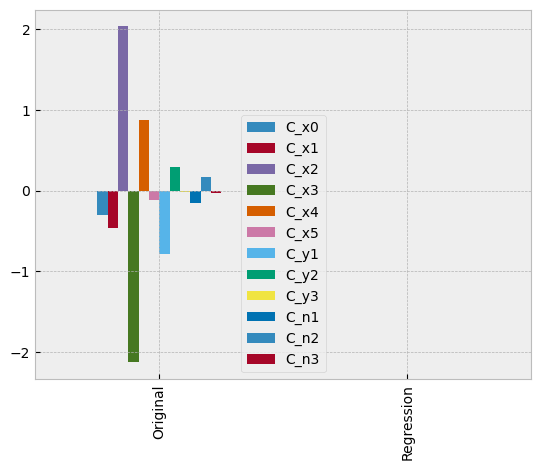

In [106]:
df_compare.plot.bar()

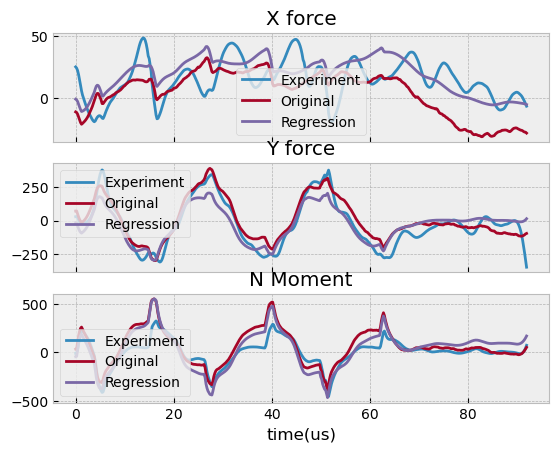

In [107]:
plot_total_force(model={'Original':model_original, 'Regression':model}, data=data);

In [108]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

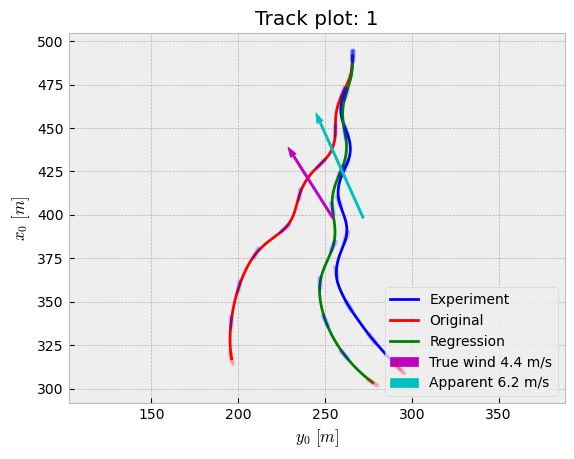

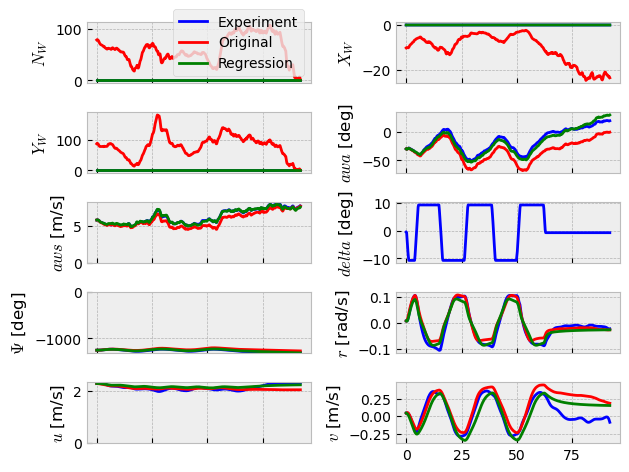

In [109]:
result = model.simulate(data)
result_original = model_original.simulate(data)

dataframes = {
    'Experiment':data,
    'Original':result_original,   
    'Regression':result,
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','X_W','Y_W','N_W'], time_window=time_window, units=units, symbols=symbols_dict);